# Spotify Top 50 exploration 

This notebook analyzes the features of the most popular tracks on Spotify and the artists behind them. We explore characteristics such as loudness, danceability, and duration of tracks and the relations between them.


In [375]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline
# pd.set_option('display.max_rows', None)

In [376]:
path = "data/spotifytoptracks.csv"

spotify = pd.read_csv(path)

# Instead of making it into the index,
# we'll replace the unnamed column for a rank column for calculations.

spotify.rename(columns={"Unnamed: 0": "rank"}, inplace=True)

spotify["rank"] += 1

spotify.head(3)

,rank,artist,album,track_name,track_id,energy,danceability,key,loudness,acousticness,speechiness,instrumentalness,liveness,valence,tempo,duration_ms,genre
0,1,The Weeknd,After Hours,Blinding Lights,0VjIjW4GlUZAMYd2vXMi3b,0.730,0.514,1,-5.934,0.00146,0.0598,0.000095,0.0897,0.334,171.005,200040,R&B/Soul
1,2,Tones And I,Dance Monkey,Dance Monkey,1rgnBhdG2JDFTbYkYRZAku,0.593,0.825,6,-6.401,0.68800,0.0988,0.000161,0.1700,0.540,98.078,209755,Alternative/Indie
2,3,Roddy Ricch,Please Excuse Me For Being Antisocial,The Box,0nbXyq5TXYPCO7pr3N8S4I,0.586,0.896,10,-6.687,0.10400,0.0559,0.000000,0.7900,0.642,116.971,196653,Hip-Hop/Rap


In [377]:
# Converting duration from ms to 'minutes:seconds' for easier interpretation.

spotify["duration_time"] = pd.to_datetime(spotify["duration_ms"], unit="ms")

spotify["duration_time"] = spotify["duration_time"].dt.strftime("%M:%S")

spotify.head(3)

,rank,artist,album,track_name,track_id,energy,danceability,key,loudness,acousticness,speechiness,instrumentalness,liveness,valence,tempo,duration_ms,genre,duration_time
0,1,The Weeknd,After Hours,Blinding Lights,0VjIjW4GlUZAMYd2vXMi3b,0.730,0.514,1,-5.934,0.00146,0.0598,0.000095,0.0897,0.334,171.005,200040,R&B/Soul,03:20
1,2,Tones And I,Dance Monkey,Dance Monkey,1rgnBhdG2JDFTbYkYRZAku,0.593,0.825,6,-6.401,0.68800,0.0988,0.000161,0.1700,0.540,98.078,209755,Alternative/Indie,03:29
2,3,Roddy Ricch,Please Excuse Me For Being Antisocial,The Box,0nbXyq5TXYPCO7pr3N8S4I,0.586,0.896,10,-6.687,0.10400,0.0559,0.000000,0.7900,0.642,116.971,196653,Hip-Hop/Rap,03:16


In [378]:
def print_function(title: str, data, newline=False, end_space=False):
    """
    Prints the provided data with a title. 
    Supports pandas DataFrame, Series, and other data types.

    Parameters:
        title (str): The title to the printed data.
        data: The data to be printed, can be of any type.
        newline(bool, optional): Adds a newline after the title if True. 
        Defaults to False.
        end_space (bool, optional): Prints an extra newline at the end. 
        Defaults to False.
    Returns:
        None
    """
    title_suffix = "\n\n" if newline else ""

    if isinstance(data, (pd.DataFrame, pd.Series)):
        print(
            f"- {title}:{title_suffix}", data.to_string(header=False)
        )  # Use to_string for pandas types without headers
    else:
        print(
            f"- {title}:{title_suffix}", data
        )  # This will handle other data types by using the default print.

    if end_space:
        print("\n")

## 1. Handling missing and duplicate values.

In [379]:
# Handling missing values.

print_function("Are there any missing values?", spotify.isnull().any().any())

# Removing duplicate samples and features.

if spotify.duplicated().any():
    print("Removing duplicates...")
    spotify.drop_duplicates(inplace=True)
else:
    print("- There are no duplicates")

- Are there any missing values?: False
- There are no duplicates


## 2. Outlier Detection

Below we calculate the Interquartile Range (IQR) to identify outliers in the dataset. Outliers can skew the results of certain variables in our data, so it is important to detect them.

In [380]:
# Define a mask with numerical values, as that is the type to find outliers.

numeric_vars_mask = ~(spotify.dtypes == "object")

numeric_vars_mask

# Generate a new dataframe with just numeric values to perform outlier detection.

numeric_df = spotify[spotify.dtypes[numeric_vars_mask].index]

# Interquartile range: diference between the last and first quartiles.

Q1 = numeric_df.quantile(0.25)
Q3 = numeric_df.quantile(0.75)
IQR = Q3 - Q1

# Define outliers as those above 1.5 times the IQR and make a dataframe out of it.

outliers = numeric_df[
    (numeric_df < (Q1 - 1.5 * IQR)) | (numeric_df > (Q3 + 1.5 * IQR))
]

# Merge the dataframe with a the column of the track names for readability.

outliers_df = spotify[["track_name"]].merge(
    outliers, left_index=True, right_index=True
)

outliers_df.head(3)

,track_name,rank,energy,danceability,key,loudness,acousticness,speechiness,instrumentalness,liveness,valence,tempo,duration_ms
0,Blinding Lights,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000095,NaN,NaN,NaN,NaN
1,Dance Monkey,NaN,NaN,NaN,NaN,NaN,0.688,NaN,0.000161,NaN,NaN,NaN,NaN
2,The Box,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.79,NaN,NaN,NaN


In [381]:
for i in range(1, outliers_df.shape[1]):
    feature = outliers_df.columns[i]
    outlier_count = outliers_df.iloc[:, i].notnull().sum()
    print_function(f"Outliers in {feature}", outlier_count)

- Outliers in rank: 0
- Outliers in energy: 0
- Outliers in danceability: 3
- Outliers in key: 0
- Outliers in loudness: 1
- Outliers in acousticness: 7
- Outliers in speechiness: 6
- Outliers in instrumentalness: 12
- Outliers in liveness: 3
- Outliers in valence: 0
- Outliers in tempo: 0
- Outliers in duration_ms: 2


## 3. Observations and features

#### How many observations are there in this dataset?

In [382]:
print_function("Number of observations in dataset", spotify.shape[0])

- Number of observations in dataset: 50


#### How many features are there in this dataset?

In [383]:
print_function("Number of features in dataset", spotify.shape[1])

- Number of features in dataset: 18


#### Which of the features are categorical?

In [384]:
print_function(
    "Categorical features", spotify.dtypes[~numeric_vars_mask], newline=True
)

- Categorical features:

 artist           object
album            object
track_name       object
track_id         object
genre            object
duration_time    object


#### Which of the features are numeric?

In [385]:
print_function(
    "Numeric features", spotify.dtypes[numeric_vars_mask], newline=True
)

- Numeric features:

 rank                  int64
energy              float64
danceability        float64
key                   int64
loudness            float64
acousticness        float64
speechiness         float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
duration_ms           int64


## 4. Artists' popularity

#### Are there any artists that have more than 1 popular track? If yes, which and how many?

In [386]:
# First, we make a Series for the number of hits an artist has

artist_hits = spotify.groupby("artist").size()

print_function(
    "Artists with more than 1 hit",
    spotify.groupby("artist")
    .size()[artist_hits > 1]
    .sort_values(ascending=False),
    newline=True,
)

- Artists with more than 1 hit:

 Billie Eilish    3
Dua Lipa         3
Travis Scott     3
Harry Styles     2
Justin Bieber    2
Lewis Capaldi    2
Post Malone      2


#### Who was the most popular artist?

In [387]:
max_size = artist_hits.max()

print_function(
    "Artists with more hits in the top 50",
    artist_hits[artist_hits == max_size],
    newline=True,
)

- Artists with more hits in the top 50:

 Billie Eilish    3
Dua Lipa         3
Travis Scott     3


In [388]:
%%capture

# Plotting different weighting functions for ranks

ranks = spotify.loc[:, "rank"].values

# Different types of weights
inverse_weights = 1 / ranks
exponential_weights = np.exp(-0.05 * ranks)  # decay rate can be adjusted
logarithmic_weights = 1 / np.log2(ranks + 1)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(ranks, inverse_weights, label="Inverse Weight (1/rank)", marker="o")
plt.plot(ranks, exponential_weights, label="Exponential Decay", marker="x")
plt.plot(ranks, logarithmic_weights, label="Logarithmic Decay", marker="^")
plt.title("Decay of Weights by Rank")
plt.xlabel("Rank")
plt.ylabel("Weight")
plt.grid(True)
plt.legend()
plt.xticks(ranks, rotation=90)
plt.show()

In [389]:
%%capture


def most_popular(df: pd.DataFrame) -> str:
    """
    Calculates the most popular artist in a DataFrame based on an exponential decay
    ranking weighting and the number of times each artist appears (hits).

    Parameters:
        df (pd.DataFrame): DataFrame containing at least 'artist' and the rankings
        of artists in the DataFrame index.

    Returns:
        str: The name of the most popular artist based on the calculated score.
    """

    # Weighting each ranking by an exponential decay with a rate of -0.05
    df["weight"] = np.exp(-0.05 * df.index)

    # Grouping the weights by artist and summing them
    weighted_scores = df.groupby("artist")["weight"].sum()

    # Counting the number of tracks each artist has in the DataFrame
    artist_tracks = df.groupby("artist").size()

    # Computing a final score by multiplying weighted scores by the number of hits
    popularity_scores = weighted_scores * artist_tracks

    # Normalizing the scores for easier interpretation (0 to 1)
    max_popularity = popularity_scores.max()
    normalized_scores = popularity_scores / max_popularity

    df["popularity_score"] = df["artist"].map(normalized_scores)

    del df["weight"]

    return df


most_popular(spotify)

# most_popular(spotify).sort_values(by='popularity_score', ascending=False)

In [390]:
print_function(
    "Top 10 artists by new popularity score",
    spotify.groupby("artist")
    .popularity_score.mean()
    .sort_values(ascending=False)
    .head(10),
    newline=True,
    end_space=True,
)

print_function(
    "Most popular artist", spotify.artist[spotify.popularity_score.idxmax()]
)

- Top 10 artists by new popularity score:

 Dua Lipa         1.000000
Harry Styles     0.648277
Lewis Capaldi    0.646020
Billie Eilish    0.610262
Justin Bieber    0.427754
Post Malone      0.419631
Travis Scott     0.344949
The Weeknd       0.297169
Tones And I      0.282676
Roddy Ricch      0.268890


- Most popular artist: Dua Lipa


#### How many artists in total have their songs in the top 50?

In [391]:
print_function("Number of artists in the top 50", artist_hits.index.size)

- Number of artists in the top 50: 40


## 5. Popular albums

#### Are there any albums that have more than 1 popular track? If yes, which and how many?

In [392]:
album_popularity = spotify.groupby("album").size() > 1

print_function(
    "Albums with more than one hit in the Top 50",
    spotify.groupby("album")
    .size()[album_popularity]
    .sort_values(ascending=False),
    newline=True,
)

- Albums with more than one hit in the Top 50:

 Future Nostalgia        3
Changes                 2
Fine Line               2
Hollywood's Bleeding    2


#### How many ? 

In [393]:
print_function(
    "Number of albums with more than one hit in the Top 50",
    spotify.groupby("album").size()[album_popularity].count(),
)

- Number of albums with more than one hit in the Top 50: 4


#### How many albums in total have their songs in the top 50?

In [394]:
print_function("Number of albums in the Top 50", album_popularity.count())

- Number of albums in the Top 50: 45


## 6. Track features

### 6.1 Danceability

#### Which tracks have a danceability score above 0.7?

In [395]:
high_danceability = spotify["danceability"] > 0.7

print_function(
    "Tracks with danceability higher than 0.7",
    spotify[["track_name", "danceability"]]
    .sort_values(by="danceability", ascending=False)
    .loc[high_danceability],
    newline=True,
)

- Tracks with danceability higher than 0.7:

 27                WAP (feat. Megan Thee Stallion)  0.935
2                                         The Box  0.896
39                                        Ride It  0.880
28                                    Sunday Best  0.878
33               Supalonely (feat. Gus Dapperton)  0.862
40                                     goosebumps  0.841
49                                     SICKO MODE  0.834
15                                   Toosie Slide  0.830
1                                    Dance Monkey  0.825
29                    Godzilla (feat. Juice WRLD)  0.808
14                       Intentions (feat. Quavo)  0.806
10                                           Tusa  0.803
19                     Life Is Good (feat. Drake)  0.795
4                                 Don't Start Now  0.793
22                                    Breaking Me  0.789
17                                         Say So  0.787
3                           Roses - Imanbe

#### Which tracks have a danceability score below 0.4?

In [396]:
print_function(
    "Tracks with danceability lower than 0.4",
    spotify[["track_name", "danceability"]][spotify.danceability < 0.4],
    newline=True,
)

- Tracks with danceability lower than 0.4:

 44  lovely (with Khalid)  0.351


### 6.2 Loudness

#### Which tracks have their loudness higher -5?

In [397]:
print_function(
    "Tracks with loudness higher than -5",
    spotify[["track_name", "loudness"]]
    .sort_values(by="loudness", ascending=False)
    .loc[spotify.loudness > -5],
    newline=True,
)

- Tracks with loudness higher than -5:

 10                                           Tusa -3.280
40                                     goosebumps -3.370
31                                 Break My Heart -3.434
38                                          Hawái -3.454
12                                        Circles -3.497
23                         Mood (feat. iann dior) -3.558
21                                      Adore You -3.675
49                                     SICKO MODE -3.714
48                                       Physical -3.756
35                Rain On Me (with Ariana Grande) -3.764
43                                        Safaera -4.074
6                                Watermelon Sugar -4.209
39                                        Ride It -4.258
37  Sunflower - Spider-Man: Into the Spider-Verse -4.368
32                                       Dynamite -4.410
4                                 Don't Start Now -4.521
17                                         Say 

#### Which tracks have their loudness lower than -8?

In [398]:
print_function(
    "Tracks with loudness lower than -8",
    spotify[["track_name", "loudness"]]
    .sort_values(by="loudness", ascending=False)
    .loc[spotify.loudness < -8],
    newline=True,
)

- Tracks with loudness lower than -8:

 20                Savage Love (Laxed - Siren Beat)  -8.520
8                                          Falling  -8.756
36                             HIGHEST IN THE ROOM  -8.764
7                 death bed (coffee for your head)  -8.765
15                                    Toosie Slide  -8.820
47  If the World Was Ending - feat. Julia Michaels -10.086
44                            lovely (with Khalid) -10.109
26                                         bad guy -10.965
24                             everything i wanted -14.454


### 6.3 Length

#### Which track is the longest?

In [399]:
print_function(
    "Longest track",
    spotify[["track_name", "duration_time"]].loc[spotify.duration_ms.idxmax()],
    newline=True,
)

- Longest track:

 track_name       SICKO MODE
duration_time         05:12


#### Which track is the shortest?

In [400]:
print_function(
    "Shortest track",
    spotify[["track_name", "duration_time"]].loc[spotify.duration_ms.idxmin()],
    newline=True,
)

- Shortest track:

 track_name       Mood (feat. iann dior)
duration_time                     02:20


### 6.4 Track popularity

#### Which genre is the most popular?

In [401]:
print_function(
    "Most popular genre", spotify.genre[spotify.groupby("genre").size().max()]
)

- Most popular genre: Pop


#### Which genres have just one song on the top 50?

In [402]:
print_function(
    "Genres with just one song in the top 50",
    spotify.groupby("genre").size()[spotify.groupby("genre").size() == 1],
    newline=True,
)

- Genres with just one song in the top 50:

 Alternative/reggaeton/experimental    1
Chamber pop                           1
Dance-pop/Disco                       1
Disco-pop                             1
Dreampop/Hip-Hop/R&B                  1
Hip-Hop/Trap                          1
Nu-disco                              1
Pop rap                               1
Pop/Soft Rock                         1
R&B/Hip-Hop alternative               1


#### How many genres in total are represented in the top 50?

In [403]:
print_function(
    "Number of genres represented in the top 50", spotify.genre.unique().size
)

- Number of genres represented in the top 50: 16


## 7. Correlations between features

#### Which features are strongly positively correlated?

In [404]:
correlations = (
    spotify.corr(numeric_only=True)
    .stack()
    .sort_values(ascending=False)
    .drop_duplicates()
)

In [405]:
strong_pos_thresh = 0.5  # Arbitrary threshold

print_function(
    "Strongly positive correlated features",
    correlations[(correlations >= strong_pos_thresh) & (correlations < 1)],
    newline=True,
)

- Strongly positive correlated features:

 energy  loudness    0.79164


#### Which features are strongly negatively correlated?

In [406]:
strong_neg_thresh = -0.5

print_function(
    "Strongly negative correlated features",
    correlations[(correlations <= strong_neg_thresh)],
    newline=True,
)

- Strongly negative correlated features:

 loudness      instrumentalness   -0.553735
acousticness  energy             -0.682479


#### Which features are not correlated?

In [407]:
not_corr_thresh = 0.1

print_function(
    "Not correlated features",
    correlations[(abs(correlations) < not_corr_thresh)],
    newline=True,
)

- Not correlated features:

 rank              speechiness         0.095790
duration_ms       energy              0.081971
tempo             rank                0.081289
key               tempo               0.080475
popularity_score  loudness            0.077087
energy            tempo               0.075191
speechiness       energy              0.074267
liveness          energy              0.069487
duration_ms       loudness            0.064130
energy            key                 0.062428
speechiness       valence             0.053867
valence           tempo               0.045089
popularity_score  duration_ms         0.044085
rank              loudness            0.034935
energy            rank                0.030381
instrumentalness  speechiness         0.028948
energy            popularity_score    0.027652
liveness          tempo               0.025457
key               instrumentalness    0.020802
instrumentalness  tempo               0.018853
popularity_score  tempo        

<Axes: >

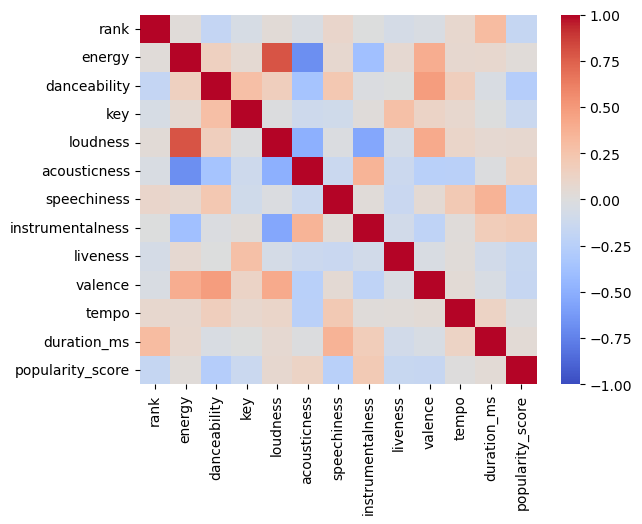

In [408]:
sns.heatmap(
    spotify.corr(numeric_only=True), cmap="coolwarm", center=0, vmin=-1, vmax=1
)

### Some comments regarding the correlations:

1. Loudness is an objective measure, while energy is probably not. Does loudness cause a more energetic feel? Worth inquiring.
2. lnstrumentalness, unsurprisingly, is negatively correlated with loudness. This may be because of the focus on textures and dynamism in more instrumental tracks. 
3. Note that energy does not have much to do with tempo, which explains why Hip-hop and Reggaeton tracks may feel very energetic besides their low tempo.

These insights might help to curate playlists according to certain feelings or according to specific purposes. For example, a playlist for exercising might include tracks with greater loudness as it is a feature that might make people feel energic. The same might apply for playlists dedicated to study or focused work: people may get exhausted by repeatedly hearing loud tracks, and vocals might also be distracting, so less loud, instrumental tracks can make a good fit for these kind of playlists. 

## 8. Descriptive statistics of Pop, Hip-Hop/Rap, Dance/Electronic, and Alternative/Indie genres

### 8.1 Danceability distribution

#### How does danceability compare between Pop, Hip-Hop/Rap, Dance/Electronic, and Alternative/Indie genres?

In [409]:
selected_genres = [
    "Pop",
    "Hip-Hop/Rap",
    "Dance/Electronic",
    "Alternative/Indie",
]

# We'll create a new dataframe based on the selected genres to generate graphs

spotify_filtered = spotify[spotify["genre"].isin(selected_genres)]

In [410]:
# We'll create a function for creating a boxplot, as we will use boxplots many times.


def create_boxplot(
    data: pd.DataFrame, by: str, column: str, title: str, ylabel: str
):
    """
    Calculates and plots the mean of a specified column
    grouped by another column in the provided dataframe.

    Parameters:
        data (pd.DataFrame): The DataFrame containing the data to plot.
        by (str): The column name in the DataFrame to group data by. 
        column (str): The numerical data column to plot.
        title (str): The title of the boxplot.
        ylabel (str): The label for the Y-axis.

    Returns:
        None: Does not return any value but shows a matplotlib plot.

    """
    plt.figure(figsize=(10, 6), dpi=300)
    data.boxplot(by=by, column=[column], grid=True)
    plt.title(title)
    plt.suptitle("")  # Suppress the default title to clean up the plot
    plt.xlabel("\n" + by)
    plt.ylabel(ylabel + "\n")
    plt.show()

In [423]:
def mean_plot(
    data: pd.DataFrame, by: str, column: str, title: str, ylabel: str
):
    """
    Calculates and plots the mean of a specified column
    grouped by another column in the provided dataframe.

    Parameters:
        data (pd.DataFrame): The DataFrame containing the data to plot.
        by (str): The column name to group the data by. 
        column (str): The numerical data column to be averaged.
        title (str): The title of the plot.
        ylabel (str): The label for the Y-axis.

    Returns:
        None: Does not return any value but shows a matplotlib plot.
    """
    means = data.groupby(by)[column].mean()

    # Creating a bar plot
    plt.figure(figsize=(8, 4))
    means.plot(kind="bar", color="lightgreen", width=0.6)
    plt.title(title)
    plt.xlabel("\n" + by)
    plt.ylabel(ylabel + "\n")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

In [412]:
spotify.groupby("genre").danceability.describe().loc[selected_genres]

,count,mean,std,min,25%,50%,75%,max
genre,,,,,,,,
Pop,14.0,0.677571,0.109853,0.464,0.61575,0.690,0.76275,0.806
Hip-Hop/Rap,13.0,0.765538,0.085470,0.598,0.72600,0.774,0.83000,0.896
Dance/Electronic,5.0,0.755000,0.094744,0.647,0.67400,0.785,0.78900,0.880
Alternative/Indie,4.0,0.661750,0.211107,0.459,0.49050,0.663,0.83425,0.862


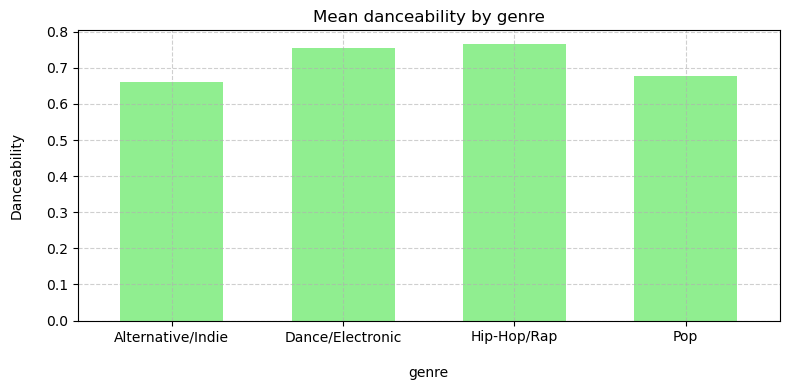

In [413]:
mean_plot(
    spotify_filtered,
    "genre",
    "danceability",
    "Mean danceability by genre",
    "Danceability",
)

<Figure size 3000x1800 with 0 Axes>

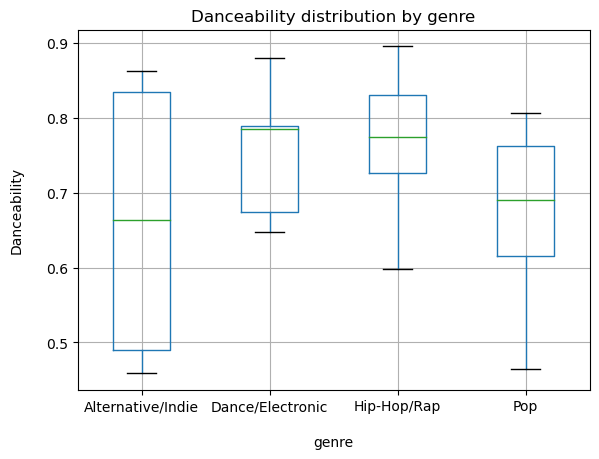

In [414]:
create_boxplot(
    spotify_filtered,
    "genre",
    "danceability",
    "Danceability distribution by genre",
    "Danceability",
)

#### Some insights about danceability distribution:

1. Alternative/indie has the highest variability
2. Hip-Hop and Dance have the greatest mean danceability
3. Hip-hop has the highest danceability track

### 8.3 Loudness distribution

#### How does the loudness score compare between Pop, Hip-Hop/Rap, Dance/Electronic, and Alternative/Indie genres?

In [415]:
spotify.groupby("genre").loudness.describe().loc[selected_genres]

,count,mean,std,min,25%,50%,75%,max
genre,,,,,,,,
Pop,14.0,-6.460357,3.014281,-14.454,-7.17875,-6.6445,-3.87525,-3.280
Hip-Hop/Rap,13.0,-6.917846,1.891808,-8.820,-8.52000,-7.6480,-5.61600,-3.370
Dance/Electronic,5.0,-5.338000,1.479047,-7.567,-5.65200,-5.4570,-4.25800,-3.756
Alternative/Indie,4.0,-5.421000,0.774502,-6.401,-5.85950,-5.2685,-4.83000,-4.746


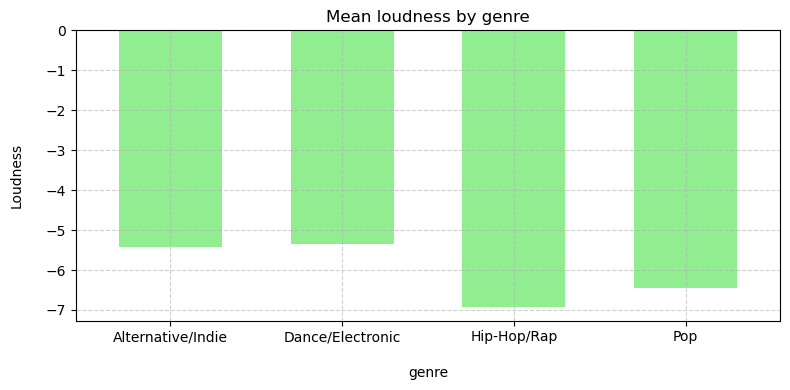

In [416]:
mean_plot(
    spotify_filtered, "genre", "loudness", "Mean loudness by genre", "Loudness"
)

<Figure size 3000x1800 with 0 Axes>

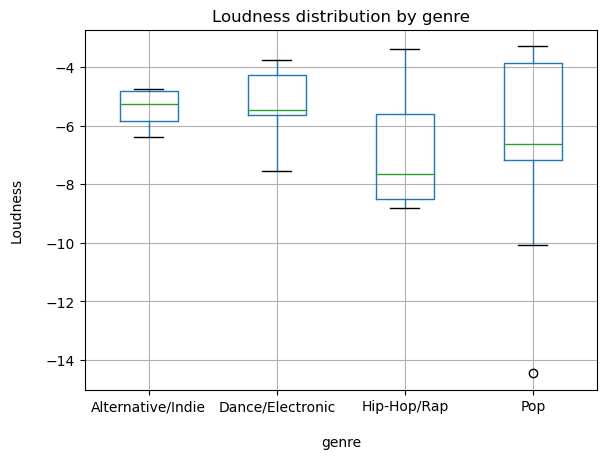

In [417]:
create_boxplot(
    spotify_filtered,
    "genre",
    "loudness",
    "Loudness distribution by genre",
    "Loudness",
)

#### Some insights about loudness distribution:

1. Dance and Alternative/indie are the loudest
2. Pop has the greatest variability 
3. Pop has an outlier with the lowest loudness score

In [418]:
print_function(
    "Who is the outlier?",
    spotify[["artist", "track_name"]].iloc[spotify_filtered.loudness.idxmin()],
    newline=True,
)

- Who is the outlier?:

 artist              Billie Eilish
track_name    everything i wanted


### 8.4 Acousticness distribution

#### How does acousticness compare between Pop, Hip-Hop/Rap, Dance/Electronic, and Alternative/Indie genres?

In [419]:
spotify.groupby("genre").acousticness.describe().loc[selected_genres]

,count,mean,std,min,25%,50%,75%,max
genre,,,,,,,,
Pop,14.0,0.323843,0.318142,0.02100,0.05990,0.2590,0.34800,0.902
Hip-Hop/Rap,13.0,0.188741,0.186396,0.00513,0.06700,0.1450,0.23400,0.731
Dance/Electronic,5.0,0.099440,0.095828,0.01370,0.01490,0.0686,0.17700,0.223
Alternative/Indie,4.0,0.583500,0.204086,0.29100,0.52575,0.6460,0.70375,0.751


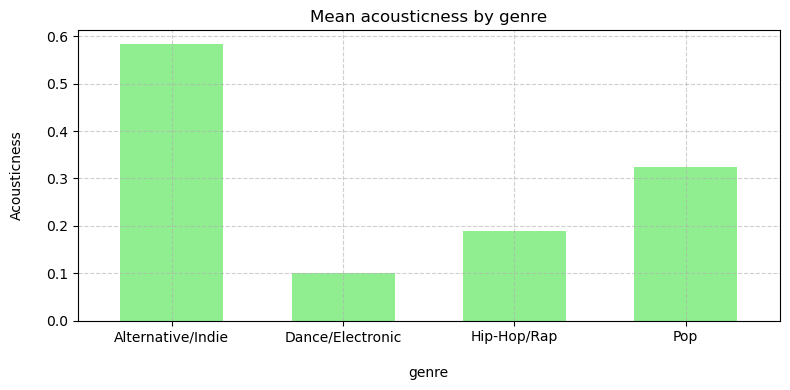

In [420]:
mean_plot(
    spotify_filtered,
    "genre",
    "acousticness",
    "Mean acousticness by genre",
    "Acousticness",
)

<Figure size 3000x1800 with 0 Axes>

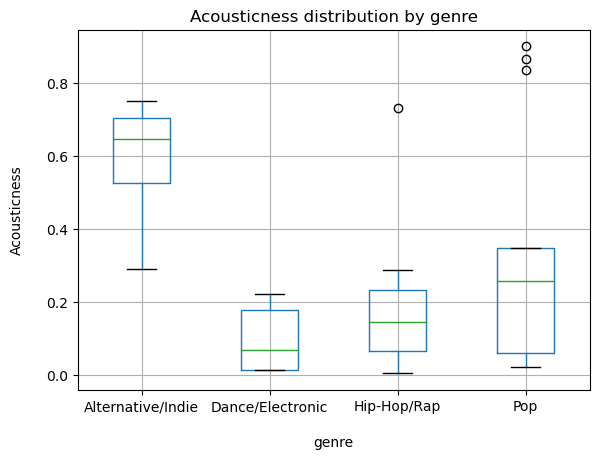

In [421]:
create_boxplot(
    spotify_filtered,
    "genre",
    "acousticness",
    "Acousticness distribution by genre",
    "Acousticness",
)

#### Some insights about acousticness distribution:

1. Alternative/indie has the greatest mean acousticness by far 
2. Pop has a lot of outliers
3. Pop shows the greatest variability

In [422]:
print_function(
    "Who are the outliers?",
    spotify_filtered[["artist", "track_name", "genre"]].loc[
        spotify_filtered.sort_values(by="acousticness", ascending=False)[
            :5
        ].index
    ],
    newline=True,
)

- Who are the outliers?:

 24  Billie Eilish                             everything i wanted                Pop
47        JP Saxe  If the World Was Ending - feat. Julia Michaels                Pop
18       Maroon 5                                        Memories                Pop
9   Lewis Capaldi                               Someone You Loved  Alternative/Indie
7           Powfu                death bed (coffee for your head)        Hip-Hop/Rap
